# Changes:
Reload saved model and troubleshoot low score

In [1]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz

% matplotlib inline

In [2]:
def rle_encoder2d(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    s = pd.Series(x.clip(0,1).flatten('F'))
    s.index = s.index+1
    df = s.to_frame('pred').assign(zero_cumcnt=s.eq(0).cumsum())
    df = df.loc[df.pred.gt(0)]
    df_rle = df.reset_index().groupby('zero_cumcnt').agg({'index': min, 'pred': sum}).astype(int).astype(str)
    rle = ' '.join((df_rle['index'] + ' '+df_rle['pred']).tolist())
    
    return rle

In [3]:
def rle_encoder3d(x):   
    return np.r_[[rle_encoder2d(e) for e in x]]

In [4]:
def load_img_to_df(img_path, normalize=False, mean_img=None, img_dtype=np.float):
    images = []
    for filename in glob.glob(f'{img_path}/*.png'): #assuming gif
        img_id = filename.split('\\')[-1].split('.')[0]
        img = np.array(imageio.imread(filename), dtype=img_dtype)
        if normalize:
            img -= mean_img[:,:,None]
        images.append([img_id, img])
    return pd.DataFrame(images, columns=['img_id', 'img']).set_index('img_id')

In [5]:
def load_img_to_np(img_path):
    images = []
    for filename in glob.glob(f'{img_path}/*.png'): #assuming gif
        img_id = filename.split('\\')[-1].split('.')[0]
        images.append(np.array(imageio.imread(filename), dtype=np.uint8))
    return np.r_[images]

In [6]:
def load_single_img(path, show=False):
    img = np.array(imageio.imread(path), dtype=np.uint8)
    if show:
        plt.imshow(img)
    return img

In [7]:
def format_train_data(X):
    X = np.moveaxis(X, -1,1)
    X = np.pad(X, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    return torch.from_numpy(X).float()

In [8]:
def get_train_batch(X_train, y_train, batch_size):
    batch_ids = np.random.choice(len(X_train), batch_size, replace=False)
    X_train_batch = X_train[batch_ids]
    X_train_batch = np.moveaxis(X_train_batch, -1,1)
    X_train_batch = np.pad(X_train_batch, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    y_train_batch = np.clip(y_train[batch_ids],0,1)
    
    return (torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float())

In [44]:
def calc_iou(a, b):
    thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    
    a = np.clip(a, 0, 1)
    b = np.clip(b, 0, 1)
    u = np.sum(np.clip(a+b, 0, 1), (1,2)).astype(np.float)
    i = np.sum(np.where((a+b)==2, 1, 0), (1,2)).astype(np.float)
    #u[u==0]=np.nan
    #iou = np.nan_to_num(i/u)
    with np.errstate(divide='ignore',invalid='ignore'):
        iou = np.where(i==u, 1, np.where(u==0, 0, i/u))
    iou_mean = (iou[:,None]>thresholds).mean(1).mean()
    
    return iou_mean

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
def get_current_time_as_fname():
        timestamp = (
                dt.datetime.now(pytz.timezone('Australia/Melbourne'))
                .strftime('%Y_%m_%d_%H_%M_%S')
                )
                
        return timestamp

In [12]:
def plot_img_mask_pred(image, mask, pred):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(pred)
    axarr[0].grid()
    axarr[1].grid()
    axarr[2].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    axarr[2].set_title('Predicted Mask')

In [13]:
class SaltNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3,64,3, padding=10),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        out = self.seq(X)
        return out[:,:,:-1,:-1].squeeze()

In [15]:
def adjust_predictions(black_img_mean, zero_mask_cut_off, mean_img, X, y_pred, y=None):
    y_pred_adj = y_pred.clip(0,1)

    # Set predictions to all 0 for black images
    black_img_mask = ((X+mean_img[None,:,:,None]).mean((1,2,3))<black_img_mean)
    y_pred_adj[black_img_mask]=0

    # set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
    y_pred_adj = np.r_[[e if e.sum()>zero_mask_cut_off else np.zeros_like(e) for e in y_pred_adj]]
    
    if y is not None:
        print(f'IOU score before: {calc_iou(y_pred, y)}, IOU Score after:{calc_iou(y_pred_adj, y)}')
        
    return y_pred_adj

In [16]:
def show_img_grid():
    pass
    #plt.imshow(torchvision.utils.make_grid(torch.from_numpy(y_train_black).unsqueeze(1)).permute(1, 2, 0))

## Constant and Parameter Defination

In [17]:
BLACK_IMG_MEAN = 50
ZERO_MASK_CUTOFF = 120

## Load Data

In [18]:
mean_img = load_img_to_np('./data/train/images').mean((0,3))

In [19]:
df_train = load_img_to_df('./data/train/images', normalize=True, mean_img=mean_img)

In [20]:
df_train['mask'] = load_img_to_df('./data/train/masks/', img_dtype=np.uint8)['img']

In [21]:
df_test = load_img_to_df('./data/test/images', normalize=True, mean_img=mean_img)

In [22]:
X_test = np.r_[df_test.img.tolist()]

In [23]:
X_test.mean()

-0.6330799240815195

## Train Val data split

In [24]:
X_train, X_val, y_train, y_val = (
    train_test_split(df_train, df_train['mask'], 
                     test_size=0.20, 
                     random_state=42)
)

In [25]:
X_train = np.r_[X_train.img.tolist()]

In [26]:
X_val = np.r_[X_val.img.tolist()]

In [27]:
y_train = np.r_[y_train.tolist()]

In [28]:
y_val = np.r_[y_val.tolist()]

## Create a Model

In [29]:
saltnet = SaltNet()

In [30]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

In [31]:
start = time.time()

In [32]:
TRAIN_MODE = False

In [33]:
if TRAIN_MODE:
    for i in range(2500):
        X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=64)
        y_pred = saltnet(X_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Loss is {loss} at iter {i}, Time: {timeSince(start)}')
            
    state = {'epoch': i + 1, 'state_dict': saltnet.state_dict(),
                 'optimizer': optimizer.state_dict() }
    ckp_name = f'saltnet_{get_current_time_as_fname()}.ckp'
    torch.save(state, ckp_name)

## Load checkpoint

In [34]:
state = torch.load('saltnet_v1_20180808_0837.cpt')

In [35]:
saltnet.load_state_dict(state['state_dict'])

### Set model to evaluation mode

In [36]:
saltnet.eval()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [38]:
assert saltnet.training == False

### Make Predictions on validation set

In [39]:
X_val_torch = format_train_data(X_val)

In [40]:
with torch.no_grad():
    y_val_pred = saltnet(X_val_torch)

y_val_pred = y_val_pred.ge(0.5).detach().numpy()

314
178
270


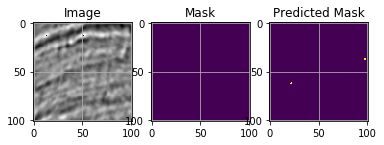

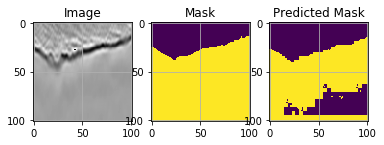

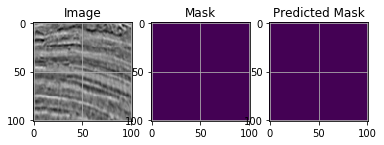

In [47]:
for i in range(3):
    rand_id = np.random.choice(len(X_val))
    print(rand_id)
    val_img = X_val[rand_id] + mean_img[:,:,None]
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred[rand_id]
    plot_img_mask_pred(val_img, val_mask, val_mask_pred)

In [48]:
y_val_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_val, y_val_pred, y_val)

IOU score before: 0.477375, IOU Score after:0.607125


## Make predictions on test set

In [50]:
y_test_pred_raw = []

In [51]:
for x in np.split(X_test, 36):
    with torch.no_grad():
        y_test_pred_raw.append(saltnet(format_train_data(x)))

In [52]:
y_test_pred_raw = torch.cat(y_test_pred_raw)

In [53]:
y_test_pred = y_test_pred_raw.ge(0.5).detach().numpy()

### Show segmentation masks for a few images

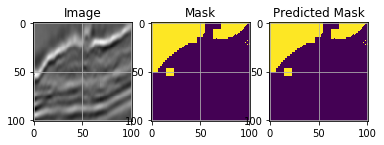

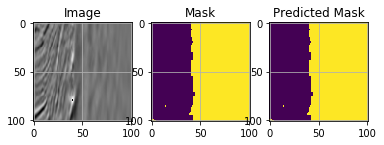

In [84]:
for i in range(2):
    rand_id = np.random.choice(len(X_test))
    #print(rand_id)
    img = X_test[rand_id] + mean_img[:,:,None]
    #mask = y_train[rand_id]
    mask_pred = y_test_pred[rand_id]
    plot_img_mask_pred(img, mask_pred, mask_pred)

### Adjust predictions

In [55]:
y_test_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_test, y_test_pred)

### Encode predictions using RLE(Run Length Encoding) method

In [56]:
y_test_pred_rle = rle_encoder3d(y_test_pred)

In [57]:
df_test_rle = pd.DataFrame(index=df_test.index, data=y_test_pred_rle).reset_index()

In [58]:
df_test_rle.columns = ['id', 'rle_mask']

In [59]:
df_test_rle[df_test_rle.rle_mask==''].shape

(6665, 2)

In [60]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)